In [67]:
import numpy as np
import xarray as xr
from numpy import ma
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature
import pandas as pd
from sklearn.decomposition import pca
from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd
from scipy import interpolate
import seaborn as sns

from MapXtremePCIC import MapXtremePCIC

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [68]:
PATH = '/storage/data/projects/nrc/CanRCM4_large_ensemble/daily/processed/hdd/*_ta.nc'

In [69]:
from datacube import read_data, load_mask
from operators import *
from eof import *

In [70]:
ds = read_data(PATH)

heating_degree_days_per_time_period


In [71]:
ds = read_data(PATH)

heating_degree_days_per_time_period


In [170]:
mask = load_mask('./mask.nc')

dv_field = ds['dv']

mask_dict = mask_land_and_nan(dv_field, mask)
idx = mask_dict['idx']

area = np.reshape(frac_grid_area(dv_field), dv_field.shape[1]*dv_field.shape[2])

mean = np.repeat(ens_mean(mask_dict['ens']), mask_dict['ens'].shape[1], axis=0)
area = np.repeat(area[idx], mask_dict['ens'].shape[1], axis=0)

mean = mean.reshape(mask_dict['ens'].shape)
area_flat = area.reshape(mask_dict['ens'].shape)

corr_ens = mask_dict['ens']*area_flat - mean

mask_corr_dict = {'ens': corr_ens, 'idx': idx} 
# get nan values in field
ens = ens_to_eof(corr_ens)
ens.shape

(8445, 1)

In [196]:
print(dv_field.shape)
idx_arr = np.flipud(np.arange(dv_field.shape[1]*dv_field.shape[2]).reshape(dv_field.shape[1], dv_field.shape[2]))

(35, 130, 155)


(442,)

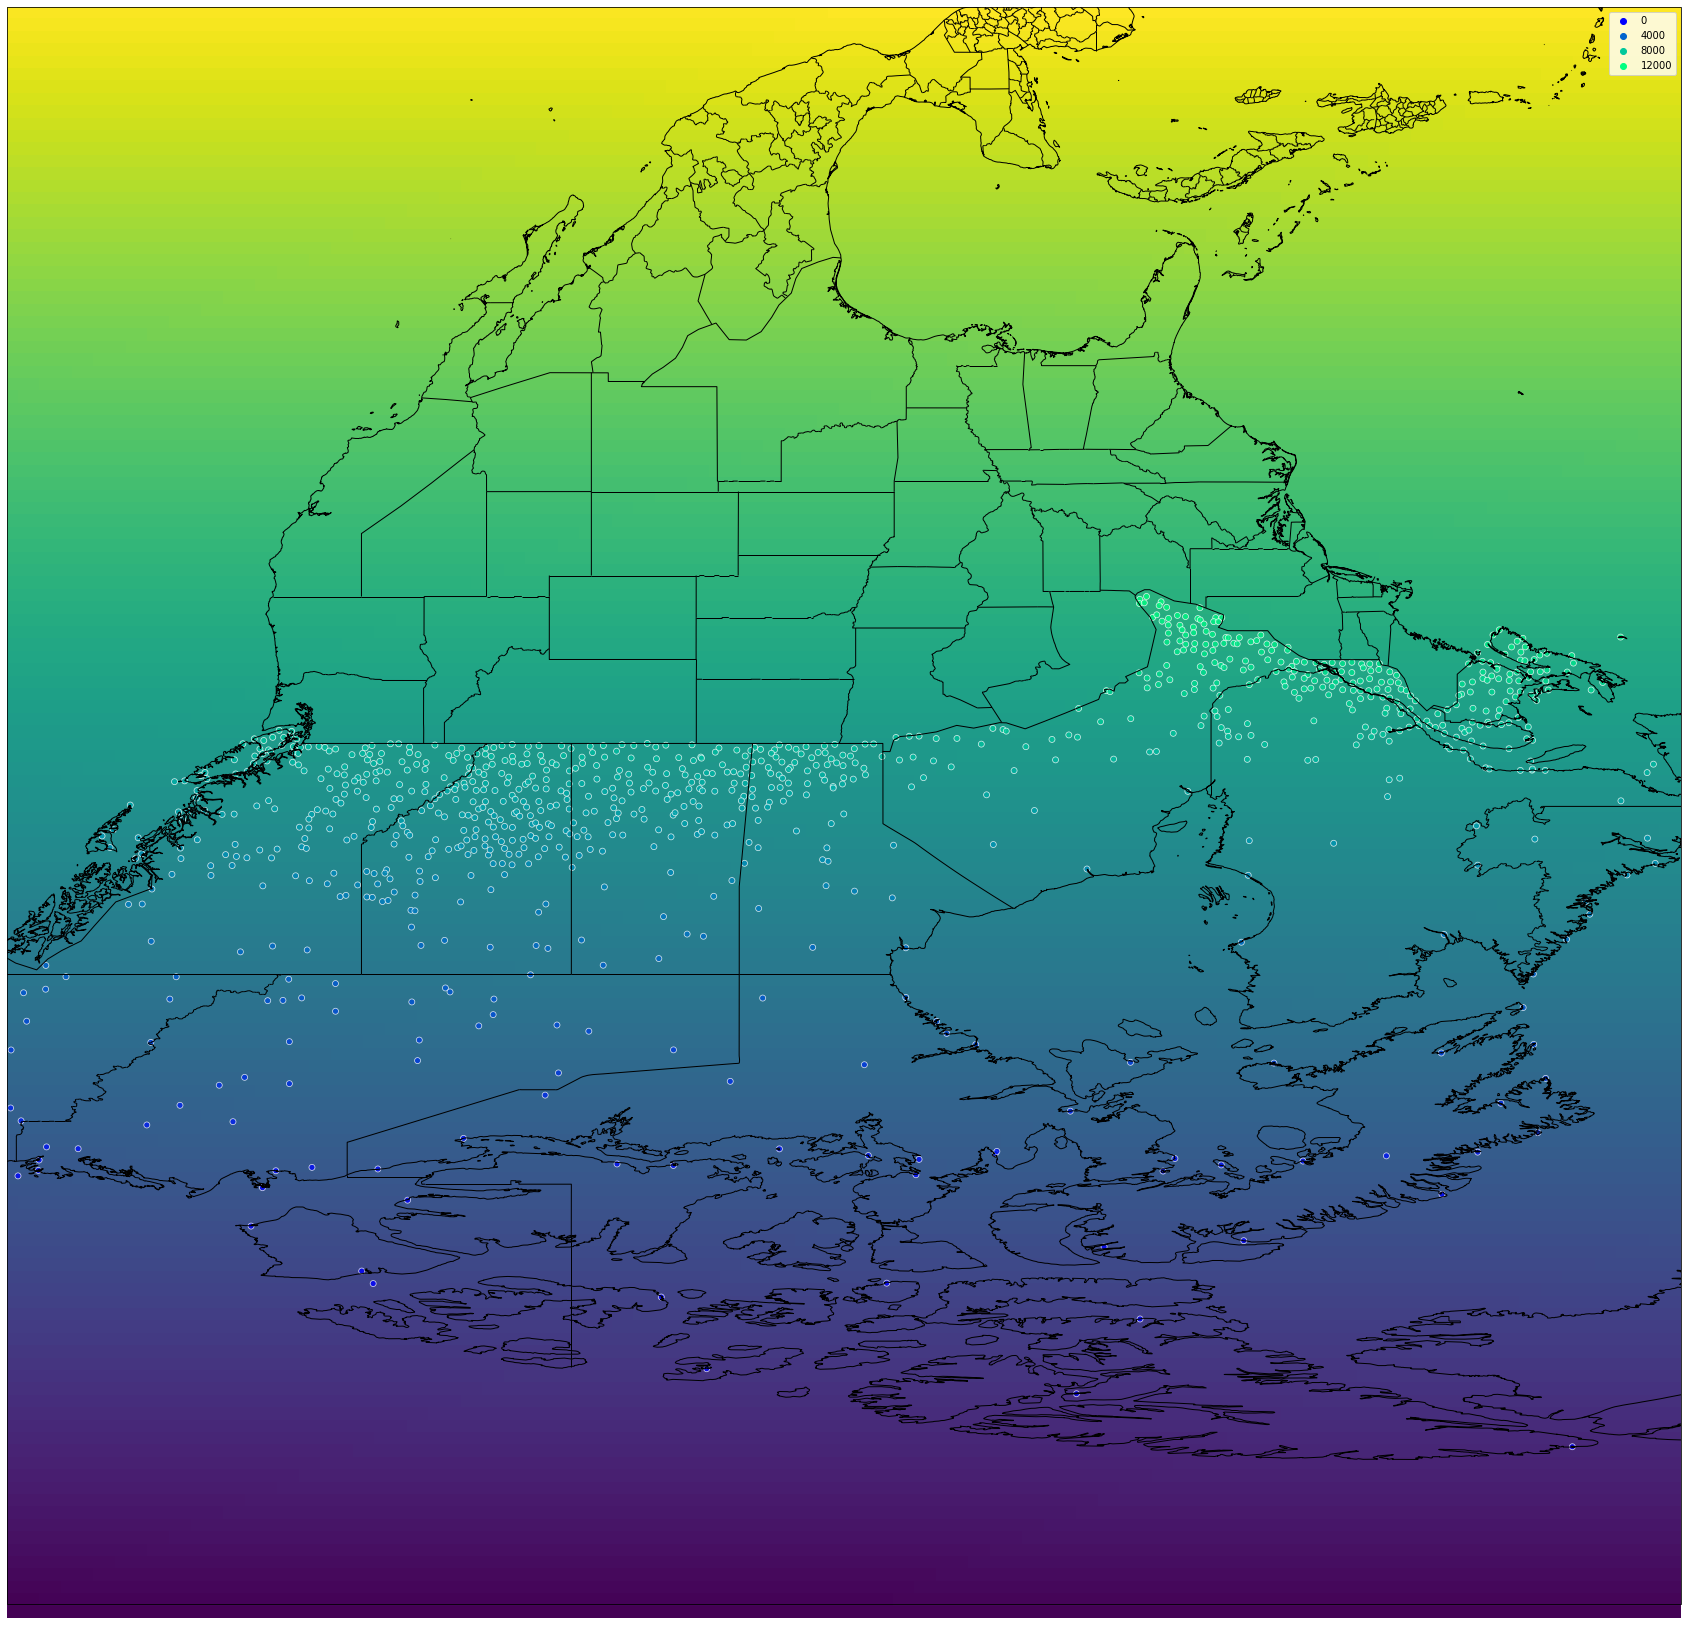

In [198]:
# gridder

df = pd.read_csv('jan_1st_percentile_1991_2016', index_col=None)

dv_lon, dv_lat = np.array(dv_field['rlon']-97), np.array(dv_field['rlat']+42.5)


def find_nearest(dv_lon, dv_lat, coord):
    lat, lon = coord
    rlon_idx = (np.abs(dv_lon - lon)).argmin()
    rlat_idx = (np.abs(dv_lat - lat)).argmin()
    return rlon_idx, rlat_idx, 

obs_lat, obs_lon = df['lat'], df['lon']

obs_lat, obs_lon
idx_list = []
for i, data in enumerate(obs_lat):
    idx_list.append(
        find_nearest(dv_lon, 
                     dv_lat, 
                     (obs_lat[i], 
                      obs_lon[i])
                    )
    )
    
# reminder to self: x and y are the indices in rlat and rlon where 
# the observations land on. We need to get the model values 
# from these points from the EOF'd ensemble array!
x, y = zip(*idx_list)
df['lonidx'], df['latidx'] = np.asarray(x), np.asarray(y)
df
ndf = df.groupby(['lonidx', 'latidx'])[['lat', 'lon', 'lonidx', 'latidx', 'quantile']].mean()
y, x = ndf['lonidx'].values, ndf['latidx'].values

from mapper import *

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt


fig = plt.figure(figsize = (30, 45))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution='10m')

states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(states_provinces, edgecolor='black')
ax.add_feature(cfeature.BORDERS)

#sns.scatterplot(x='lon', y='lat', data=df_1, hue='dd_sum')#

#df_new = df_1[(df_1['lat'] < 61.0)&(df_1['lat'] > 45.0)&(df_1['lon'] > -138)&(df_1['lon'] < -114)]

sns.scatterplot(ndf['lon'], ndf['lat'], hue=idx_arr[x, y], palette="winter", alpha=.8)
plt.imshow(idx_arr, extent=[
                            np.amin(dv_lon)-6, 
                            np.amax(dv_lon)+6,
                            np.amax(dv_lat)+20,
                            np.amin(dv_lat)]
)
#ens[idx_arr[x, y]]
ens_matched_cells = np.isin(mask_corr_dict['idx'], idx_arr[x, y])
np.where(ens_matched_cells == True)[0].shape

#mask_corr_dict['idx'], np.sort(idx_arr[y, x])
#idx_list
#obs = df['quantile']*area_flat[ens_matched_cells][:, 0]

In [51]:
dv_field = ds['dv']

mean = ens_mean(dv_field)
area = frac_grid_area(dv_field)

mask = mask_flat(dv_field, mask_nan(dv_field))

# area weighted ens to get obs
ens_obs = ens_flat(dv_field*area)

# mask
ens_obs = ens_obs[:, ~mask.mask]

# get random ens to generate
# the pseudo obs
obs = get_obs(ens_obs)
obs_idx = rand_sample_index(obs, 0.02)
obs_sample = obs[obs_idx]

ens = ens_flat(dv_field*area - mean)
ens = ens[:, ~mask.mask]
ens = ens_to_eof(ens.T)[:, 0]
ens_obs = ens[obs_idx]
model = regress_eof(ens_obs, obs_sample)
pred_flat = predict_dv(model, ens)

pred = pred_to_grid(dv_field, pred_flat, mask_nan(dv_field))
pred = (pred/area + mean)

pred.shape

plt.scatter(obs, pred_flat, marker='+',s=1.5, alpha = 0.15)
plt.plot(np.linspace(-0.000, 0.0005, 10),
         np.linspace(-0.000, 0.0005, 10), 'r')
plt.xlim(0.0, 0.0007)
plt.ylim(0.0, 0.0007)
plt.title("Observations vs. Reconstructed Observations")
plt.xlabel("CanRCM4 Field Value")
plt.ylabel("Predicted Observations")
plt.savefig("plots/obs_reonstructed.pdf")

NameError: name 'mask_nan' is not defined

In [606]:
y = get_obs(ds)
ensemble = ensemble_reshape(ds)
ensemble.shape

AttributeError: 'Dataset' object has no attribute 'shape'

In [133]:
ensemble_eof = ensemble_to_eof(ensemble)

ens_cross_eof = ensemble_eof[index, :] 

model = regress_eof(ens_cross_eof, y)
predictions = predict_dv(model, ensemble_eof)

ds_eof = reconstruct_eof_full(predictions, ds)

(35, 124, 149)
(35, 124, 149)
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

<xarray.DataArray 'eofs' (eofs: 18476)>
array([     nan,      nan, 0.000278, ...,      nan,      nan, 0.000135])
Coordinates:
  * eofs     (eofs) float64 nan nan 0.0002782 nan ... nan nan 0.0001347

In [91]:
fit_transform(ds)

Model score: 0.6725304497264397


<xarray.Dataset>
Dimensions:  (eofs: 18476, rlat: 124, rlon: 149, run: 35)
Coordinates:
  * rlon     (rlon) float64 -32.56 -32.12 -31.68 -31.24 ... 31.68 32.12 32.56
  * rlat     (rlat) float64 -27.28 -26.84 -26.4 -25.96 ... 25.96 26.4 26.84
  * eofs     (eofs) float64 nan nan 9.58e-10 nan ... nan nan 4.373e-10
Dimensions without coordinates: run
Data variables:
    lon      (run, rlat, rlon) float64 233.5 233.8 234.2 ... 332.0 332.5 333.0
    lat      (run, rlat, rlon) float64 14.04 14.2 14.36 ... 59.87 59.56 59.26
    dv       (run, rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes:
    Author:        Chao Li @ PCIC - chaoli@uvic.ca
    Institution:   Pacific Climate Impacts Consortium
    Date created:  Tue Aug 28 00:13:00 2018

ValueError: x and y must be the same size

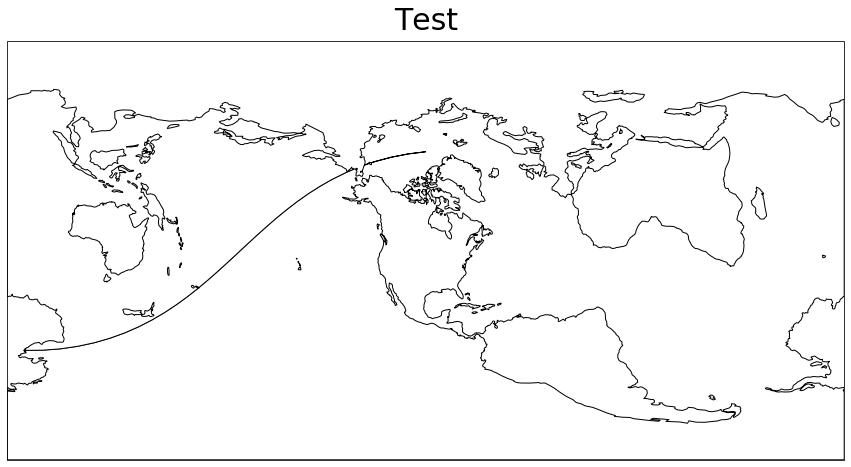

In [97]:
from mapper import *

plot_reference(ds, 'Test')